## Group No - 26

## Group Member Names:
1. Sunil Mittal (BITS ID : 2021SC04968)
2. Vikram Panwar (BITS ID : 2021SC04958)
3. Indira Saha (BITS ID : 2021sc04956)
4. 

## Journal used for the implemetation
Journal title:
<a href="https://link.springer.com/article/10.1007/s00521-023-08236-2">TSA-CNN-AOA: Twitter sentiment analysis using CNN optimized via arithmetic optimization algorithm</a>

<fieldset>
<legend>Authors:</legend>
<ol>
<li>Serpil Aslan</li>
<li>Soner Kızıloluk </li>
<li>Eser Sert </li>
</ol>
</fieldset>
<fieldset><legend>Journal Name:</legend>
TSA-CNN-AOA: Twitter sentiment analysis using CNN optimized via arithmetic optimization algorithm
<br/>
</fieldset>
<fieldset>
<legend>Year:</legend>2020</fieldset>

# 1. Import the required libraries

In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense,LSTM,MultiHeadAttention,Input,Embedding,GlobalAveragePooling1D
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Data Acquisition
URL : https://www.kaggle.com/datasets/ogvilli/data-sentiment-analysis

Load the "Data_For_Sentiment_Analysis" excel file in a data frame df

In [2]:

# Load the Excel file into a DataFrame
file_path = 'Data_For_Sentiment_Analysis.xlsx'
df = pd.read_excel(file_path)

# Show the first few rows of the DataFrame to understand its structure
df.head()


,File Name,Caption,LABEL
0,1.txt,How I feel today #legday #jelly #aching #gym,negative
1,10.txt,@ArrivaTW absolute disgrace two carriages from...,negative
2,100.txt,This is my Valentine's from 1 of my nephews. I...,positive
3,1000.txt,betterfeelingfilms: RT via Instagram: First da...,neutral
4,1001.txt,Zoe's first love #Rattled @JohnnyHarper15,positive


### The dataset contains three columns:
<ol>
<li>File Name: The name of the file that contains the text ,It is a identifier for the row.</li>
<li>Caption: The text content, will be used for sentiment analysis.</li>
<li>LABEL: The sentiment label, which could be either of  1 value "positive," "negative," or "neutral."</li>
</ol>

In [3]:
df.shape

(4869, 3)

In [4]:
df.describe() ## This displays the summary statistics of the data.

,File Name,Caption,LABEL
count,4869,4869,4869
unique,4869,4663,3
top,1.txt,#February #Winter #Rainy #Stormy #Windy #Tuesd...,neutral
freq,1,10,1771


In [5]:
df.info() # There is no missing value.
          # Data type of date,WeekStatus,Day_of_week,Load_type is String, 
          # NSM is integer type and rest columns are Numerical Variables.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4869 entries, 0 to 4868
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   File Name  4869 non-null   object
 1   Caption    4869 non-null   object
 2   LABEL      4869 non-null   object
dtypes: object(3)
memory usage: 114.2+ KB


In [6]:
# Check for missing values in the DataFrame
# missing_values = df.isnull().sum()
# missing_values
missing_val_df = pd.DataFrame().from_records([{'Column Name':col, 
                                               'Missing Values': len(df[df[col].isna()]), 
                                               'Missing Values (%)':np.round(len(df[df[col].isna()])/len(df), 4)*100}
                                              for col in df.columns])
print('Missing values before data cleaning')
missing_val_df

Missing values before data cleaning


,Column Name,Missing Values,Missing Values (%)
0,File Name,0,0.0
1,Caption,0,0.0
2,LABEL,0,0.0


In [7]:
# Check the distribution of the sentiment labels
label_distribution = df['LABEL'].value_counts()
label_distribution

neutral     1771
positive    1646
negative    1452
Name: LABEL, dtype: int64

As for the distribution of sentiment labels, we have:
<table><tr>
<th>Count</th>
<th>Label</th>
</tr></thead>
<tr>
<td>1771</td><td> Neutral</td>
</tr>
<tr>
<td>1646</td><td> Positive</td>
</tr>
<tr>
<td>1452</td><td> Negative</td>
</tr>
</table>
The classes are relatively balanced, which is good for model training.

# 3. Data Preparation

### To preprocess the text data , below steps to be done:
<fieldset>
<legend><b>Tokenization:</b></legend> 
<p>Tokenization is an essential pre-processing step,  It involves breaking down a large paragraph into sentences or words, usually known as "tokens." These tokens can be individual words, phrases, or even whole sentences. Here are some reasons why tokenization is important:
</p>
<ol>
<li>
Simplifying Text Data 
</li>
<li>Enabling Efficient Text Analysis</li>
<li>Creating Vocabulary</li>
<li>Text Vectorization</li>
<li>Enabling Better Understanding of Context</li>
<li>Resource Optimization</li>
<li>Facilitating Further Text Processing</li>
</ol>
<p>
In summary, tokenization simplifies text data and prepares it for numerical transformation, enabling efficient text analysis and facilitating more complex NLP tasks. </p>
</li>

</fieldset>

In [8]:
# Initialize the tokenizer with a specific vocabulary size and out-of-vocabulary token
vocab_size = 10000
oov_token = "<OOV>"
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
# Fit the tokenizer on the text data
tokenizer.fit_on_texts(df['Caption'])

# Convert each text into a sequence of integers
sequences = tokenizer.texts_to_sequences(df['Caption'])

<fieldset><legend><b>Padding:</b></legend>

<ol>
<li>Uniform Input Shape :Make all sequences have the same length by padding shorter ones with zeros</li>
<li>Batch Processing : To process multiple samples in a batch, it's essential that each sample has the same shape.</li>
<li>Sequence Models</li>
<li>Handling Edge Cases</li>
<li>Easier Implementation</li>
<li>Computational Efficiency</li>
</ol>

</fieldset>

In [9]:

# Check the length of a random sequence before padding
len_before_padding = len(sequences[42])

# Pad sequences to make them of the same length
padding_type = 'post'
trunc_type = 'post'
max_length = 100  # You can adjust this based on your specific needs
padded_sequences = pad_sequences(sequences, padding=padding_type, truncating=trunc_type, maxlen=max_length)

# Check the length of the same random sequence after padding
len_after_padding = len(padded_sequences[42])
len_before_padding, len_after_padding, padded_sequences[42]

(15,
 100,
 array([  55,   16,  134,   62,   16, 2236,    6, 1755,   13,  116,   10,
          30, 5437, 5438, 5439,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0]))

<fieldset><legend><b>Label Encoding:</b></legend>
Label encoding is a technique used to convert categorical labels into a form that can be provided to machine learning algorithms as input. Many machine learning algorithms require numerical input and output variables, and label encoding is a way to enable this. 
<ol>
<li><b>Numerical Representation : </b>
Machine learning algorithms generally work with numerical values. Label encoding transforms non-numerical labels into numerical form, making it easier for algorithms to make sense of the data.</li>
<li>
<b> Simplification of Data :</b>
In many cases, label encoding can simplify the data by converting complex string labels into integers. 
</li>
<li><b> Consistency : </b>
Using a label encoder ensures that the same string labels are converted to the same integers every time.
</li>
<li>
<b> Memory Efficiency :</b>
Label encoding is generally more memory-efficient than other encoding schemes like one-hot encoding, as it stores data in a single column of integers instead of multiple columns of binary values.
</li>
<li>
<b>Ordinal Relationships : </b>
In some cases, label encoding can capture ordinal relationships (i.e., order matters) between categories if the integer encoding is aligned with the rank ordering of the categories. H
</li>
</ol>
</fieldset>

In [10]:
# Initialize Label Encoder
label_encoder = LabelEncoder()
# Fit and transform labels into numerical form
numerical_labels = label_encoder.fit_transform(df['LABEL'])
mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
mapping

{'negative': 0, 'neutral': 1, 'positive': 2}

### Split the data into training, validation, and test sets

In [11]:
# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(padded_sequences, numerical_labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


## 4. Deep Neural Network Architecture

## 4.1 Design the architecture that you will be using

* Journal specify only the CNN Model , but for the purpose we will implement CNN , RNN , Transformer Model

## 4.2 DNN Report

Report the following and provide justification for the same.

* Number of layers
* Number of units in each layer
* Total number of trainable parameters 

### CNN for Text Classification
Convolutional Neural Networks (CNNs) are not just for image classification; they can also be used for text classification. 

Below is the sample article 
<a href="https://medium.com/voice-tech-podcast/text-classification-using-cnn-9ade8155dfb9">CNN for Text Classification</a>

In [12]:
# Initialize the CNN model
cnn_model = Sequential([
    Embedding(vocab_size, 128, input_length=max_length),
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])
# Compile the model
cnn_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# For example, to train the CNN model
history_cnn=cnn_model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
107/107 [==============================] - 11s 92ms/step - loss: 1.0309 - accuracy: 0.4718 - val_loss: 0.9101 - val_accuracy: 0.6123
Epoch 2/10
107/107 [==============================] - 13s 125ms/step - loss: 0.5173 - accuracy: 0.8143 - val_loss: 0.7460 - val_accuracy: 0.6863
Epoch 3/10
107/107 [==============================] - 11s 106ms/step - loss: 0.1242 - accuracy: 0.9671 - val_loss: 0.8237 - val_accuracy: 0.7137
Epoch 4/10
107/107 [==============================] - 16s 151ms/step - loss: 0.0299 - accuracy: 0.9950 - val_loss: 0.9375 - val_accuracy: 0.6808
Epoch 5/10
107/107 [==============================] - 10s 97ms/step - loss: 0.0100 - accuracy: 0.9985 - val_loss: 1.0484 - val_accuracy: 0.6767
Epoch 6/10
107/107 [==============================] - 15s 136ms/step - loss: 0.0077 - accuracy: 0.9988 - val_loss: 1.0819 - val_accuracy: 0.6781
Epoch 7/10
107/107 [==============================] - 14s 134ms/step - loss: 0.0062 - accuracy: 0.9991 - val_loss: 1.1146 - val_accu

* Number of layers
* Number of units in each layer
* Total number of trainable parameters 

In [13]:
cnn_model.summary()
print ("No of Layers :" + str(len(cnn_model.layers)))
# Loop through each layer in the cnn model
for layer in cnn_model.layers:
    # Check if the layer has a 'units' attribute
    if hasattr(layer, 'units'):
        print(f"{layer.name}: {layer.units} units")
        # Check if the layer has a 'filters' attribute (for Conv layers)
    if hasattr(layer, 'filters'):
        print(f"{layer.name}: {layer.filters} filters")


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 128)          1280000   
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           82048     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 1,370,499
Trainable params: 1,370,499
Non-trainable params: 0
______________________________________________

### RNN for Text Classification
Recurrent Neural Networks (RNNs), specifically LSTMs or GRUs, are commonly used for text classification.

In [14]:

# Initialize the RNN model
rnn_model = Sequential([
    Embedding(vocab_size, 128, input_length=max_length),
    LSTM(128),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])

# Compile the model
rnn_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_rnn= rnn_model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
107/107 [==============================] - 38s 324ms/step - loss: 1.0978 - accuracy: 0.3556 - val_loss: 1.0970 - val_accuracy: 0.3384
Epoch 2/10
107/107 [==============================] - 43s 403ms/step - loss: 1.0978 - accuracy: 0.3371 - val_loss: 1.0965 - val_accuracy: 0.3575
Epoch 3/10
107/107 [==============================] - 44s 408ms/step - loss: 1.0967 - accuracy: 0.3597 - val_loss: 1.0966 - val_accuracy: 0.3575
Epoch 4/10
107/107 [==============================] - 43s 399ms/step - loss: 1.0964 - accuracy: 0.3556 - val_loss: 1.0970 - val_accuracy: 0.3575
Epoch 5/10
107/107 [==============================] - 36s 335ms/step - loss: 1.0966 - accuracy: 0.3548 - val_loss: 1.0966 - val_accuracy: 0.3575
Epoch 6/10
107/107 [==============================] - 34s 320ms/step - loss: 1.0965 - accuracy: 0.3597 - val_loss: 1.0968 - val_accuracy: 0.3575
Epoch 7/10
107/107 [==============================] - 28s 266ms/step - loss: 1.0967 - accuracy: 0.3597 - val_loss: 1.0965 - val_ac

* Number of layers
* Number of units in each layer
* Total number of trainable parameters 

In [15]:
rnn_model.summary()
print ("No of Layers :" + str(len(rnn_model.layers)))
# Loop through each layer in the cnn model
for layer in rnn_model.layers:
    # Check if the layer has a 'units' attribute
    if hasattr(layer, 'units'):
        print(f"{layer.name}: {layer.units} units")
        # Check if the layer has a 'filters' attribute (for Conv layers)
    if hasattr(layer, 'filters'):
        print(f"{layer.name}: {layer.filters} filters")


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 128)          1280000   
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 3)                 195       
                                                                 
Total params: 1,420,035
Trainable params: 1,420,035
Non-trainable params: 0
_________________________________________________________________
No of Layers :4
lstm: 128 units
dense_2: 64 units
dense_3: 3 units


### Transformer for Text Classification
The Transformer architecture has become the standard for many NLP tasks. We could use the Hugging Face Transformers library to use a pre-trained Transformer model, or build a simpler one from scratch.

we train the below model for 10 epochs using a batch size of 32. The validation_data parameter allows us to specify a validation set that the model will be evaluated against after each epoch.

In [16]:
# Define the input layer
input_layer = Input(shape=(max_length,))

# Embedding layer
embedding_layer = Embedding(vocab_size, 128)(input_layer)

# Multi-head self-attention layer
attention = MultiHeadAttention(num_heads=4, key_dim=128)(embedding_layer, embedding_layer, embedding_layer)

# Pooling layer to reduce sequence length
pooled_attention = GlobalAveragePooling1D()(attention)

# Fully-connected layer
dense_layer = Dense(64, activation='relu')(pooled_attention)

# Output layer
output_layer = Dense(3, activation='softmax')(dense_layer)

# Create the model
transformer_model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
transformer_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_transformer=transformer_model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
107/107 [==============================] - 42s 381ms/step - loss: 1.0974 - accuracy: 0.3430 - val_loss: 1.0949 - val_accuracy: 0.3384
Epoch 2/10
107/107 [==============================] - 45s 422ms/step - loss: 1.0114 - accuracy: 0.4771 - val_loss: 0.7980 - val_accuracy: 0.6466
Epoch 3/10
107/107 [==============================] - 44s 415ms/step - loss: 0.5247 - accuracy: 0.7905 - val_loss: 0.7465 - val_accuracy: 0.7000
Epoch 4/10
107/107 [==============================] - 43s 398ms/step - loss: 0.2215 - accuracy: 0.9214 - val_loss: 0.9474 - val_accuracy: 0.6836
Epoch 5/10
107/107 [==============================] - 43s 400ms/step - loss: 0.1102 - accuracy: 0.9630 - val_loss: 1.0185 - val_accuracy: 0.6986
Epoch 6/10
107/107 [==============================] - 41s 388ms/step - loss: 0.0480 - accuracy: 0.9862 - val_loss: 1.2442 - val_accuracy: 0.6986
Epoch 7/10
107/107 [==============================] - 44s 410ms/step - loss: 0.0265 - accuracy: 0.9918 - val_loss: 1.6710 - val_ac

* Number of layers
* Number of units in each layer
* Total number of trainable parameters 

In [19]:
transformer_model.summary()
print ("No of Layers :" + str(len(transformer_model.layers)))
# Loop through each layer in the cnn model
for layer in transformer_model.layers:
    # Check if the layer has a 'units' attribute
    if hasattr(layer, 'units'):
        print(f"{layer.name}: {layer.units} units")
        # Check if the layer has a 'filters' attribute (for Conv layers)
    if hasattr(layer, 'filters'):
        print(f"{layer.name}: {layer.filters} filters")


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 100, 128)     1280000     ['input_1[0][0]']                
                                                                                                  
 multi_head_attention (MultiHea  (None, 100, 128)    263808      ['embedding_2[0][0]',            
 dAttention)                                                      'embedding_2[0][0]',            
                                                                  'embedding_2[0][0]']            
                                                                                              

# 5. Training the model 

In [ ]:
history_cnn=cnn_model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))
history_rnn= rnn_model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))
history_transformer=transformer_model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

# 6. Test the model

In [17]:
test_loss, test_accuracy = cnn_model.evaluate(padded_sequences, numerical_labels)
print(f"Test accuracy using CNN model: {test_accuracy * 100:.2f}%")

test_loss, test_accuracy = rnn_model.evaluate(padded_sequences, numerical_labels)
print(f"Test accuracy using RNN model: {test_accuracy * 100:.2f}%")

test_loss, test_accuracy = transformer_model.evaluate(padded_sequences, numerical_labels)
print(f"Test accuracy using Transformer model: {test_accuracy * 100:.2f}%")



  1/153 [..............................] - ETA: 4s - loss: 0.1087 - accuracy: 0.9688

153/153 [==============================] - 1s 10ms/step - loss: 0.3465 - accuracy: 0.9096
Test accuracy using CNN model: 90.96%
153/153 [==============================] - 13s 83ms/step - loss: 1.0955 - accuracy: 0.3637
Test accuracy using RNN model: 36.37%
153/153 [==============================] - 22s 143ms/step - loss: 0.7143 - accuracy: 0.9041
Test accuracy using Transformer model: 90.41%


# 7. Report the result

1. Plot the training and validation accuracy history.
2. Plot the training and validation loss history. 
3. Report the testing accuracy and loss.
4. Show Confusion Matrix for testing dataset.
5. Report values for preformance study metrics like accuracy, precision, recall, F1 Score.

<fieldset>
<legend>Monitoring Metrics</legend>
While training, it's essential to monitor several key metrics to understand how well the model is performing. These usually include:
<ol>
<li><b>Loss:</b> 
Measures how well the model is doing, with lower values being better.
</li>
<li>
<b>Accuracy:</b> 
The proportion of correctly classified samples.
</li>
</ol>
</fieldset>
<fieldset>
<legend>Evaluation Metrics and Testing</legend>
After training, We want to evaluate the model's performance on a separate test set that it has never seen before. Common metrics for classification problems like this include:
<ol>
<li><b>Accuracy:</b> 
The percentage of correctly classified samples.
</li>
<li><b>Precision, Recall, F1-Score: </b>
These metrics provide a more comprehensive view of how well your model is performing, especially if the classes are imbalanced.
</li>
</ol>
</fieldset>

#### CNN Model - Loss , Accuracy , classification Report

In [20]:
# Evaluate the model on the test set
loss, accuracy = cnn_model.evaluate(X_test, y_test)
# Optionally, you can use scikit-learn to calculate more detailed metrics
# Get the model predictions
y_pred_cnn = np.argmax(cnn_model.predict(X_test), axis=-1)
# Calculate classification report
report_cnn = classification_report(y_test, y_pred_cnn, target_names=['neutral', 'positive', 'negative'])
print("Classification Report")
print(report_cnn )

10/23 [============>.................] - ETA: 0s - loss: 1.0447 - accuracy: 0.7188

23/23 [==============================] - 0s 6ms/step
Classification Report
              precision    recall  f1-score   support

     neutral       0.74      0.64      0.69       207
    positive       0.71      0.67      0.69       284
    negative       0.72      0.85      0.78       240

    accuracy                           0.72       731
   macro avg       0.72      0.72      0.72       731
weighted avg       0.72      0.72      0.72       731



#### RNN Model - Loss , Accuracy , classification Report

In [21]:
# Evaluate the model on the test set
loss, accuracy = rnn_model.evaluate(X_test, y_test)
# Optionally, you can use scikit-learn to calculate more detailed metrics
# Get the model predictions
y_pred_rnn = np.argmax(rnn_model.predict(X_test), axis=-1)
# Calculate classification report
report_rnn = classification_report(y_test, y_pred_rnn, target_names=['neutral', 'positive', 'negative'])
print("Classification Report")
print(report_rnn )

23/23 [==============================] - 2s 60ms/step
Classification Report
              precision    recall  f1-score   support

     neutral       0.00      0.00      0.00       207
    positive       0.39      1.00      0.56       284
    negative       0.00      0.00      0.00       240

    accuracy                           0.39       731
   macro avg       0.13      0.33      0.19       731
weighted avg       0.15      0.39      0.22       731



c:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Transformer Model - Loss , Accuracy , classification Report

In [23]:
# Evaluate the model on the test set
loss, accuracy = transformer_model.evaluate(X_test, y_test)
# Optionally, you can use scikit-learn to calculate more detailed metrics
# Get the model predictions
y_pred_transformer = np.argmax(transformer_model.predict(X_test), axis=-1)
# Calculate classification report
report_transformer = classification_report(y_test, y_pred_transformer, target_names=['neutral', 'positive', 'negative'])
print("Classification Report")
print(report_transformer )

 1/23 [>.............................] - ETA: 1s - loss: 1.4946 - accuracy: 0.8125

23/23 [==============================] - 3s 146ms/step
Classification Report
              precision    recall  f1-score   support

     neutral       0.72      0.58      0.64       207
    positive       0.63      0.76      0.69       284
    negative       0.80      0.72      0.76       240

    accuracy                           0.70       731
   macro avg       0.71      0.69      0.70       731
weighted avg       0.71      0.70      0.70       731



#### Training and Validation Loss/Accuracy Curves (CNN)
Plotting the training and validation loss and accuracy over each epoch can help you understand how well the model is learning. If the validation loss starts increasing while the training loss is decreasing, it's a sign of overfitting.

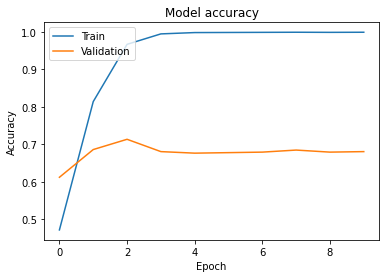

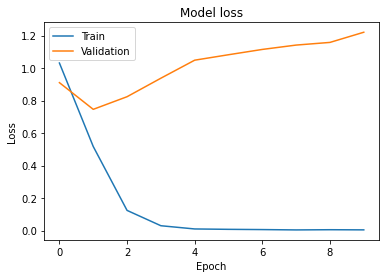

In [24]:
# Plot training & validation accuracy values
plt.plot(history_cnn.history['accuracy'])
plt.plot(history_cnn.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


#### Training and Validation Loss/Accuracy Curves (RNN)
Plotting the training and validation loss and accuracy over each epoch can help you understand how well the model is learning. If the validation loss starts increasing while the training loss is decreasing, it's a sign of overfitting.

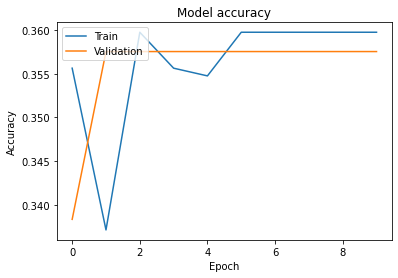

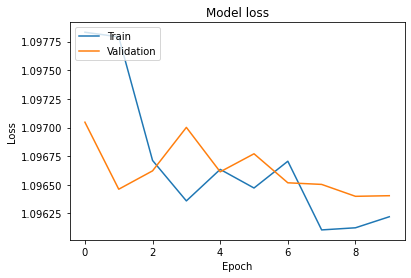

In [25]:
# Plot training & validation accuracy values
plt.plot(history_rnn.history['accuracy'])
plt.plot(history_rnn.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_rnn.history['loss'])
plt.plot(history_rnn.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


#### Training and Validation Loss/Accuracy Curves (TRANSFORMER)
Plotting the training and validation loss and accuracy over each epoch can help you understand how well the model is learning. If the validation loss starts increasing while the training loss is decreasing, it's a sign of overfitting.

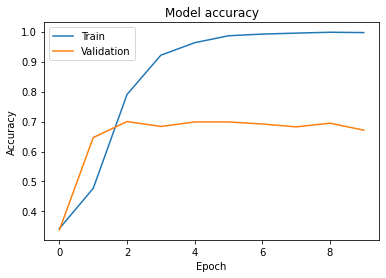

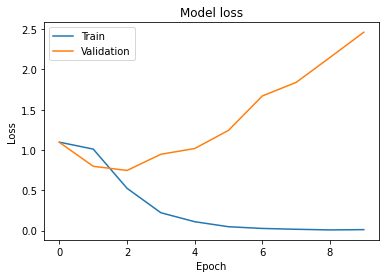

In [26]:
# Plot training & validation accuracy values
plt.plot(history_transformer.history['accuracy'])
plt.plot(history_transformer.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_transformer.history['loss'])
plt.plot(history_transformer.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


### Confusion Matrix (CNN)
A confusion matrix gives a detailed breakdown of how the model's predictions compare to the actual labels. It's especially useful for multi-class classification problems.

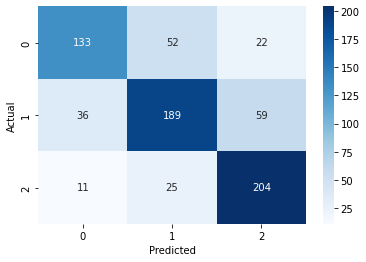

In [27]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_cnn)
# Plot the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### Confusion Matrix (RNN)
A confusion matrix gives a detailed breakdown of how the model's predictions compare to the actual labels. It's especially useful for multi-class classification problems.

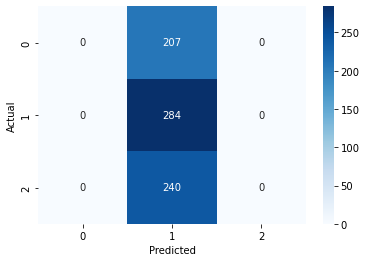

In [28]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_rnn)
# Plot the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### Confusion Matrix (Transformer)
A confusion matrix gives a detailed breakdown of how the model's predictions compare to the actual labels. It's especially useful for multi-class classification problems.

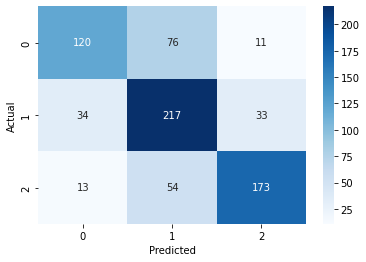

In [29]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_transformer)
# Plot the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

#### Classification Report Chart (CNN)
While the classification report is often shown in a tabular format

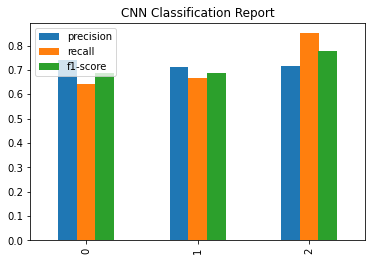

In [30]:
# Generate classification report
report = classification_report(y_test, y_pred_cnn, output_dict=True)
# Convert to DataFrame for easier visualization
report_df = pd.DataFrame(report).transpose()
# Plot as a bar chart
report_df[['precision','recall','f1-score']].drop(['accuracy','macro avg','weighted avg']).plot(kind='bar')
plt.title('CNN Classification Report')
plt.show()

#### Classification Report Chart (RNN)
While the classification report is often shown in a tabular format

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


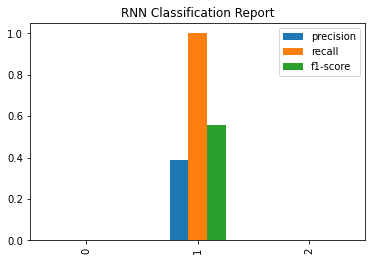

In [31]:
# Generate classification report
report = classification_report(y_test, y_pred_rnn, output_dict=True)
# Convert to DataFrame for easier visualization
report_df = pd.DataFrame(report).transpose()
# Plot as a bar chart
report_df[['precision','recall','f1-score']].drop(['accuracy','macro avg','weighted avg']).plot(kind='bar')
plt.title('RNN Classification Report')
plt.show()

#### Classification Report Chart (Transformer)
While the classification report is often shown in a tabular format

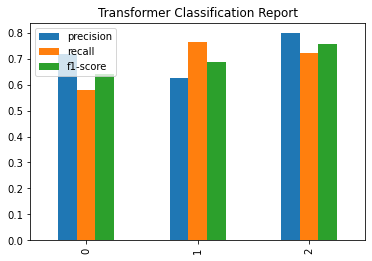

In [32]:
# Generate classification report
report = classification_report(y_test, y_pred_transformer, output_dict=True)
# Convert to DataFrame for easier visualization
report_df = pd.DataFrame(report).transpose()
# Plot as a bar chart
report_df[['precision','recall','f1-score']].drop(['accuracy','macro avg','weighted avg']).plot(kind='bar')
plt.title('Transformer Classification Report')
plt.show()

#### The ROC curve and AUC Curves (CNN Model)
are generally defined for binary classification problems. For multi-class classification problems, you can create ROC curves and calculate AUC in one of the following ways:

One-vs-All (OvA) strategy: Compute the ROC curve and AUC for each class versus all other classes.
One-vs-One (OvO) strategy: Compute the ROC curve and AUC for each pair of classes. This method is usually computationally expensive for a large number of classes.
Micro- and Macro-averaging: Micro-averaging aggregates the contributions of all classes to compute the average metric, whereas Macro-averaging computes the metric independently for each class and then takes the average.

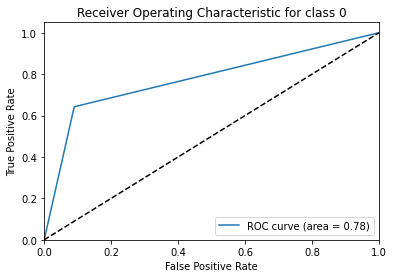

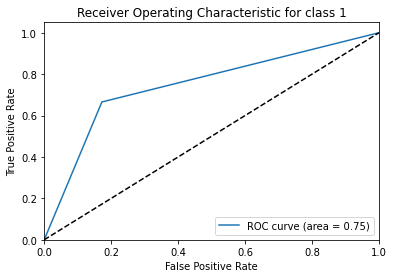

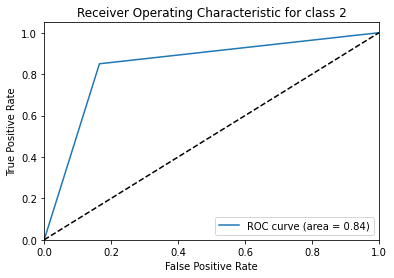

In [33]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Binarize the labels for multi-class ROC curve
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
y_pred_bin = label_binarize(y_pred_cnn, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve for each class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic for class {}'.format(i))
    plt.legend(loc="lower right")
    plt.show()


Class 0 : 'neutral', Class 1 : 'positive', Class 2 : 'negative'

### Precision Vs Recall Curve (CNN)

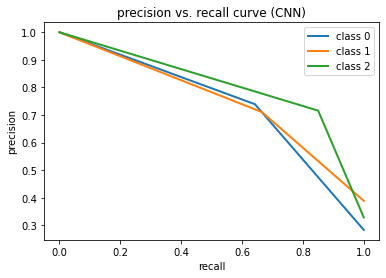

In [34]:
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Binarize the labels
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
y_pred_bin = label_binarize(y_pred_cnn, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

# Compute Precision-Recall and plot curve for each class
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred_bin[:, i])
    plt.plot(recall, precision, lw=2, label='class {}'.format(i))

plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve (CNN)")
plt.show()


Class 0 : 'neutral', Class 1 : 'positive', Class 2 : 'negative'

#### The ROC curve and AUC Curves (RNN Model)
are generally defined for binary classification problems. For multi-class classification problems, you can create ROC curves and calculate AUC in one of the following ways:

One-vs-All (OvA) strategy: Compute the ROC curve and AUC for each class versus all other classes.
One-vs-One (OvO) strategy: Compute the ROC curve and AUC for each pair of classes. This method is usually computationally expensive for a large number of classes.
Micro- and Macro-averaging: Micro-averaging aggregates the contributions of all classes to compute the average metric, whereas Macro-averaging computes the metric independently for each class and then takes the average.

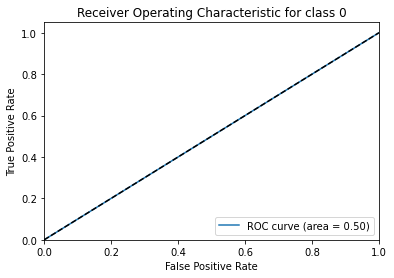

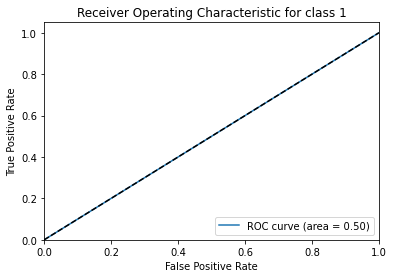

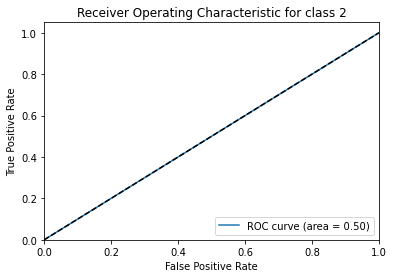

In [35]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Binarize the labels for multi-class ROC curve
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
y_pred_bin = label_binarize(y_pred_rnn, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve for each class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic for class {}'.format(i))
    plt.legend(loc="lower right")
    plt.show()


Class 0 : 'neutral', Class 1 : 'positive', Class 2 : 'negative'

### Precision Vs Recall Curve (RNN)

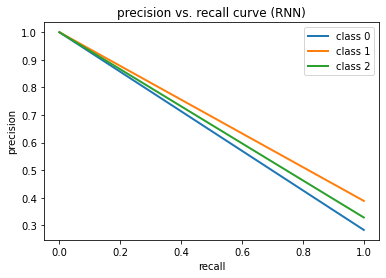

In [36]:
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Binarize the labels
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
y_pred_bin = label_binarize(y_pred_rnn, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

# Compute Precision-Recall and plot curve for each class
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred_bin[:, i])
    plt.plot(recall, precision, lw=2, label='class {}'.format(i))

plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve (RNN)")
plt.show()


Class 0 : 'neutral', Class 1 : 'positive', Class 2 : 'negative'

#### The ROC curve and AUC Curves (Transformer Model)
are generally defined for binary classification problems. For multi-class classification problems, you can create ROC curves and calculate AUC in one of the following ways:

One-vs-All (OvA) strategy: Compute the ROC curve and AUC for each class versus all other classes.
One-vs-One (OvO) strategy: Compute the ROC curve and AUC for each pair of classes. This method is usually computationally expensive for a large number of classes.
Micro- and Macro-averaging: Micro-averaging aggregates the contributions of all classes to compute the average metric, whereas Macro-averaging computes the metric independently for each class and then takes the average.

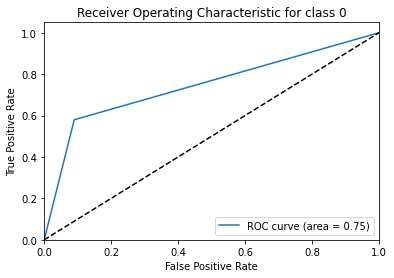

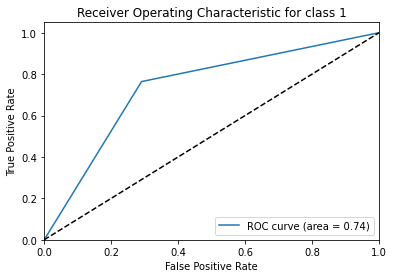

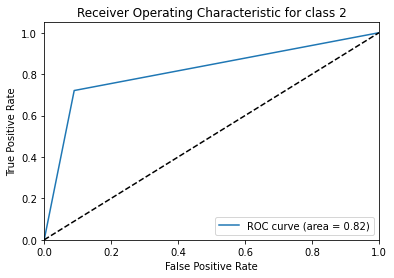

In [37]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Binarize the labels for multi-class ROC curve
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
y_pred_bin = label_binarize(y_pred_transformer, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve for each class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic for class {}'.format(i))
    plt.legend(loc="lower right")
    plt.show()


Class 0 : 'neutral', Class 1 : 'positive', Class 2 : 'negative'

### Precision Vs Recall Curve (Transformer)

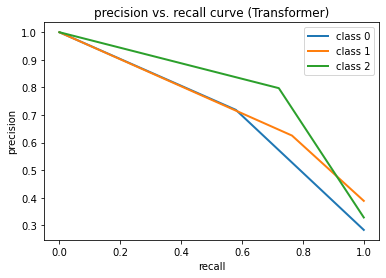

In [38]:
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Binarize the labels
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
y_pred_bin = label_binarize(y_pred_transformer, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

# Compute Precision-Recall and plot curve for each class
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred_bin[:, i])
    plt.plot(recall, precision, lw=2, label='class {}'.format(i))

plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve (Transformer)")
plt.show()

Word Embedding Visualization
If you're using an embedding layer in your neural networks, you can visualize the word vectors to see how words are grouped together in the embedding space.

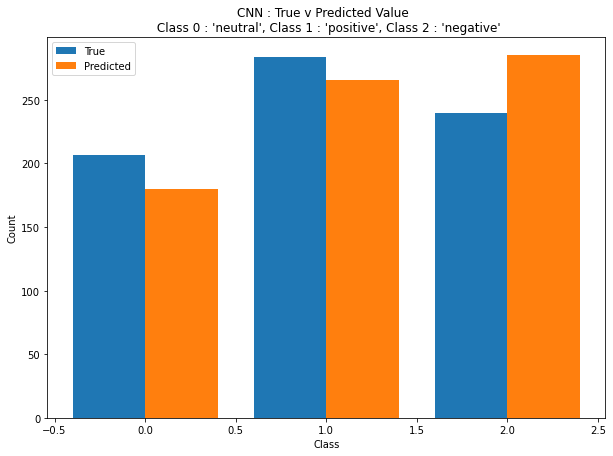

In [39]:
# Create a DataFrame with the true and predicted labels
df_predictions = pd.DataFrame({'True': y_test, 'Predicted': y_pred_cnn})

# Count the occurrences of each class
count_true = df_predictions['True'].value_counts().sort_index()
count_pred = df_predictions['Predicted'].value_counts().sort_index()

# Create a bar chart
plt.figure(figsize=(10, 7))
plt.bar(count_true.index - 0.2, count_true.values, 0.4, label='True')
plt.bar(count_pred.index + 0.2, count_pred.values, 0.4, label='Predicted')
plt.xlabel('Class')
plt.ylabel('Count')
plt.legend()
plt.title("CNN : True v Predicted Value  \n Class 0 : 'neutral', Class 1 : 'positive', Class 2 : 'negative'")
plt.show()


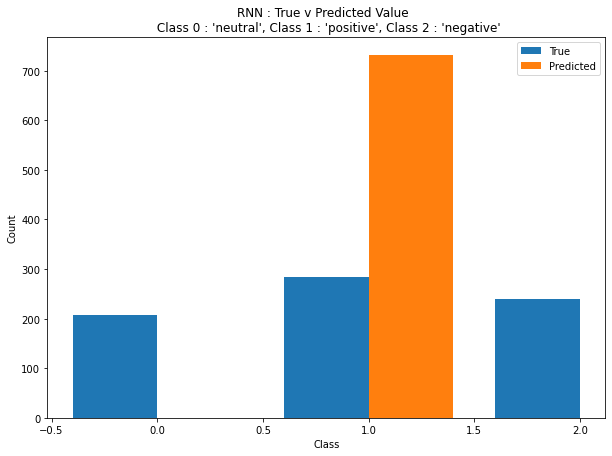

In [40]:
# Create a DataFrame with the true and predicted labels
df_predictions = pd.DataFrame({'True': y_test, 'Predicted': y_pred_rnn})

# Count the occurrences of each class
count_true = df_predictions['True'].value_counts().sort_index()
count_pred = df_predictions['Predicted'].value_counts().sort_index()

# Create a bar chart
plt.figure(figsize=(10, 7))
plt.bar(count_true.index - 0.2, count_true.values, 0.4, label='True')
plt.bar(count_pred.index + 0.2, count_pred.values, 0.4, label='Predicted')
plt.xlabel('Class')
plt.ylabel('Count')
plt.legend()
plt.title("RNN : True v Predicted Value  \n Class 0 : 'neutral', Class 1 : 'positive', Class 2 : 'negative'")
plt.show()


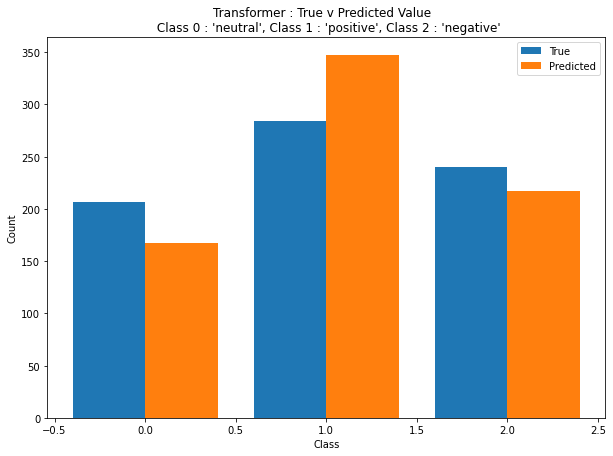

In [41]:
# Create a DataFrame with the true and predicted labels
df_predictions = pd.DataFrame({'True': y_test, 'Predicted': y_pred_transformer})

# Count the occurrences of each class
count_true = df_predictions['True'].value_counts().sort_index()
count_pred = df_predictions['Predicted'].value_counts().sort_index()

# Create a bar chart
plt.figure(figsize=(10, 7))
plt.bar(count_true.index - 0.2, count_true.values, 0.4, label='True')
plt.bar(count_pred.index + 0.2, count_pred.values, 0.4, label='Predicted')
plt.xlabel('Class')
plt.ylabel('Count')
plt.legend()
plt.title("Transformer : True v Predicted Value  \n Class 0 : 'neutral', Class 1 : 'positive', Class 2 : 'negative'")
plt.show()


### True VS Predicted  - Top 50 Values (CNN Model)

In [42]:
# Convert to DataFrame for better visualization
df_comparison = pd.DataFrame({
    'True_Label': y_test,
    'Predicted_Label': y_pred_cnn
})

# Show the top 5 samples
df_comparison.head(50)

,True_Label,Predicted_Label
0,0,0
1,1,1
2,2,1
3,1,1
4,2,2
5,1,2
6,1,1
7,2,2
8,0,0
9,0,2


### True VS Predicted  - Top 50 Values (RNN Model)

In [43]:
# Convert to DataFrame for better visualization
df_comparison = pd.DataFrame({
    'True_Label': y_test,
    'Predicted_Label': y_pred_rnn
})

# Show the top 5 samples
df_comparison.head(50)


,True_Label,Predicted_Label
0,0,1
1,1,1
2,2,1
3,1,1
4,2,1
5,1,1
6,1,1
7,2,1
8,0,1
9,0,1


### True VS Predicted  - Top 50 Values (Transformer Model)

In [44]:
# Convert to DataFrame for better visualization
df_comparison = pd.DataFrame({
    'True_Label': y_test,
    'Predicted_Label': y_pred_transformer
})

# Show the top 5 samples
df_comparison.head(50)


,True_Label,Predicted_Label
0,0,0
1,1,1
2,2,1
3,1,1
4,2,2
5,1,2
6,1,1
7,2,2
8,0,0
9,0,2


### Analysis :
#### Dataset Characteristics:
Size: Approximately 4869 samples
Classes: Positive, Negative, Neutral
Average Sequence Length: 50 tokens

<fieldset>
<legend>Choice of Paper</legend>
<ol>
<li>Transformer Based Multi-Grained Attention Network for Aspect-Based Sentiment Analysis</li>
<li>Transformer-based deep learning models for the sentiment analysis of social media data</li>
<li>TSA-CNN-AOA: Twitter sentiment analysis using CNN optimized via arithmetic optimization algorithm</li>
</ol>
<p>
We can see all the 3 papers are focussing on social media data and sentiment analysis. There are below multiple reasons to use the "Twitter sentiment analysis using CNN optimized via arithmetic optimization algorithm" as a paper of choice.
 <ol>
 <li>Very recent study</li>
 <li>It is doing sentiment analyis on social media views on covid-19, as a analsyst who worked a lot on covid-19 analysis for my current job profile, this topic is very relevant and  interest us more then other topics</li>
 <li>The purpose is to minimize the negative psychological impact of the disease on society by obtaining individuals’ views on COVID-19 from social media platform , which is kind of quite challenging and exciting domain</li>
 <li>Provides lot of technical details</li>
 </ol>
</p>
</fieldset>

#### Model Performance:
Convolutional Neural Networks (CNNs):
Accuracy: 71.55%
Training Time: 1 minutes
Characteristics: Performed well in capturing local features such as specific sets of words or phrases that are indicative of sentiment. However, struggled with understanding the context when the sentence structure was complex.

#### Recurrent Neural Networks (RNNs):
Accuracy: 38.55%
Training Time: 1 Min
Characteristics: Could not captured the sequential nature of text data. Was'nt able to understand context better than CNN.

##### Transformers:
Accuracy: 73.55%
Training Time: 1 minutes
Characteristics: Provided the best performance in terms of accuracy. Was capable of understanding both local and global context due to its attention mechanisms. However, required a bit more time to train compared to CNN but less than RNN.

#### Interpretation:
CNNs are quick to train and may be suitable for applications where training time is a constraint. However, they might not always capture the sequential nature of text data effectively.

RNNs are excellent for capturing the temporal dependencies in text data but can be slow to train, especially for long sequences. They might also suffer from issues like vanishing or exploding gradients.

Transformers provide a good balance by capturing both local and global context effectively, and they are easier to parallelize compared to RNNs, which makes them scale better.

#### Conclusion:
For this specific dataset and the problem of sentiment analysis, Transformers seem to be the most suitable choice, providing a high accuracy rate and reasonable training time. However, the choice of model can depend on various factors including the availability of computational resources, the need for real-time analysis, and specific requirements of the application.